In [28]:
%reload_ext autoreload
%autoreload

import cv2
import numpy as np
import os
import glob
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.optimize import leastsq, least_squares
from importlib import reload 
import topocalib.model_cv
from numpy.linalg import inv
from topocalib.model_cv import ls_func, get_pixel_coordinates_test, array2params
from topocalib.optimizer import optimize, optimize_pix4d
from topocalib.visualise import show_correlation_matrix, show_residuals

IMAGE_PATTERN = 'images/calib3/*.jpg'
CHECKERBOARD = (6,19)
NUM_IMAGES = 15

Checking images/calib3/15.jpg
(114, 2)
Success #1
Checking images/calib3/10.jpg
(114, 2)
Success #2
Checking images/calib3/9.jpg
(114, 2)
Success #3
Checking images/calib3/54.jpg
(114, 2)
Success #4
Checking images/calib3/58.jpg
(114, 2)
Success #5
Checking images/calib3/36.jpg
(114, 2)
Success #6
Checking images/calib3/24.jpg
(114, 2)
Success #7
Checking images/calib3/55.jpg
(114, 2)
Success #8
Checking images/calib3/61.jpg
(114, 2)
Success #9
Checking images/calib3/18.jpg
(114, 2)
Success #10
Checking images/calib3/25.jpg
(114, 2)
Success #11
Checking images/calib3/7.jpg
(114, 2)
Success #12
Checking images/calib3/14.jpg
(114, 2)
Success #13
Checking images/calib3/37.jpg
(114, 2)
Success #14
Checking images/calib3/57.jpg
(114, 2)
Success #15
(114, 3)
(114, 2)


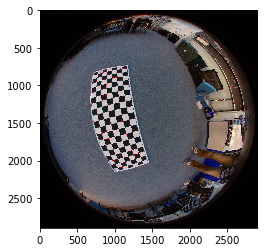

In [29]:
objps = np.zeros(shape=(CHECKERBOARD[0] * CHECKERBOARD[1], 3))
for i in range(CHECKERBOARD[0] * CHECKERBOARD[1]):
    objps[i] = np.array([ i % CHECKERBOARD[0], int(i / CHECKERBOARD[0]), 5])

    
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob(IMAGE_PATTERN)

gray = None
for fname in images:
    print('Checking %s' % fname)
    img = cv2.imread(fname)
    img = img[0:img.shape[0], 0:img.shape[0]]

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
    if ret:
        objpoints.append(objps)
        imgpoints.append(corners[:, 0])
        print(corners[:, 0].shape)
        
        for corner in corners:
            img = cv2.circle(img, (corner[0][0], corner[0][1]), 10, (255, 0, 0))
        plt.imshow(img)
        print('Success #%d' % len(objpoints))
        
    if len(objpoints) >= NUM_IMAGES:
        break


print(objpoints[0].shape)
print(imgpoints[0].shape)

### OpenCV Camera Model

First we find rotation ($R$) and translation ($T$) of camera in respect of to the world coordinates ($ X_{world} $)
\begin{equation*}
X_{camera} =  R * X_{world} + T
\end{equation*}

Pinhole projection coordinates 
\begin{equation*}
X_{homegenious} = \begin{pmatrix}
\frac{x_{camera}}{z_{camera}} \\
\frac{y_{camera}}{z_{camera}} \\
1
\end{pmatrix}
\end{equation*}

\begin{equation*}
r = \sqrt{x_{homegenious}^2 + y_{homegenious}^2}
\end{equation*}


\begin{equation*}
\theta = arctan(r)
\end{equation*}

Fisheye distortion
\begin{equation*}
\theta_{distorted} = \theta (1 + k_1 \theta^2 + k_2 \theta^4 + k_3 \theta^6 + k_3 \theta^8)
\end{equation*}

Based on $ X_{distorted} $ we can easily find coordinates in image plane
\begin{equation*}
X_{image} = 
\begin{pmatrix}
    x_{focal} & 0 \\
    0 & y_{focal}
\end{pmatrix}
\begin{pmatrix}
 \frac{\theta_{distorted} x_{homegenious}}{r} \\
 \frac{\theta_{distorted} y_{homegenious}}{r}
\end{pmatrix} + 
\begin{pmatrix}
x_{center} \\
y_{center}
\end{pmatrix}
\end{equation*}

### Pix4D Camera Model

First we find rotation ($R$) and translation ($T$) of camera in respect of to the world coordinates ($ X_{world} $)
\begin{equation*}
X_{camera} =  R * X_{world} + T
\end{equation*}

Pinhole projection coordinates 
\begin{equation*}
X_{homegenious} = \begin{pmatrix}
\frac{x_{camera}}{z_{camera}} \\
\frac{y_{camera}}{z_{camera}} \\
1
\end{pmatrix}
\end{equation*}

\begin{equation*}
r = \sqrt{x_{homegenious}^2 + y_{homegenious}^2}
\end{equation*}


\begin{equation*}
\theta = \frac{2}{\pi} arctan(r)
\end{equation*}

Fisheye distortion
\begin{equation*}
\theta_{distorted} = \theta (1 + k_1 \theta + k_2 \theta^2 + k_3 \theta^3)
\end{equation*}

Based on $ X_{distorted} $ we can easily find coordinates in image plane
\begin{equation*}
X_{image} = 
\begin{pmatrix}
    x_{focal} & D \\
    E & y_{focal}
\end{pmatrix}
\begin{pmatrix}
 \frac{\theta_{distorted} x_{homegenious}}{r} \\
 \frac{\theta_{distorted} y_{homegenious}}{r}
\end{pmatrix} + 
\begin{pmatrix}
x_{center} \\
y_{center}
\end{pmatrix}
\end{equation*}

### Calibration matrix
\begin{equation*}
\begin{pmatrix}
x_{focal} & 0 & x_{center} \\ 
0 & y_{focal} & y_{center} \\
0 & 0 & 1 
\end{pmatrix}
\end{equation*}

### Least-square Optimisation

\begin{equation*}
minimise \sum{ (X_{image} - X_{observed})^2 }
\end{equation*}

### Parameters to Be Found

Global
$ k_1, k_2, k_3, k_4, X_{focal}, X_{center} $

For each image
$ R, T $


In [31]:
%autoreload

res1 = optimize_pix4d(objpoints, imgpoints, maxiter=100)

In [32]:
%autoreload

print(res1)
# ax_res, ax_hist = show_residuals(2, objpoints, imgpoints, np.matrix(res1.T), np.matrix(res1.R), res1.D, res1.K[0, 0], res1.K[0:2, 2].A1, pix4d=True)
# show_correlation_matrix(res1.jacobian)

K = [[1.34946013e+03 0.00000000e+00 1.45168009e+03]
 [0.00000000e+00 1.34773155e+03 1.44395949e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
D = [ 0.01668148 -0.16109292  0.22340004]
time = 210.6
jacobian = [[ -634.92892456  -724.16583252  -284.73754883 ...     0.
      0.             0.        ]
 [ -389.35855865  -444.08145905  -174.61009979 ...     0.
      0.             0.        ]
 [ -581.17114258  -643.23497772  -254.62631989 ...     0.
      0.             0.        ]
 ...
 [  258.76861572   133.46949768    49.38101196 ... -1056.22280884
    269.63941956   576.79998779]
 [  -39.3348999    -18.8000946     -6.71983337 ...    85.18580627
    519.35392761 -1077.89419556]
 [  234.17196655   111.92227173    40.00515747 ... -1051.0149231
    280.03884888   660.58520508]]
R = [array([ 0.0026652 , -0.23699686, -0.76743556]), array([ 0.03862955, -0.06849733, -0.10632043]), array([ 0.0402506 , -0.02522549, -0.08486168]), array([-0.31379632, -0.9046824 , -0.35618692]), array([-0.019

### Correlation Matrix

In order to verify correlation between different parameters covariance matrix is calculated:
\begin{align}
Cov(J) = (J^T J)^{-1}
\end{align}
where J is Jacobian obtained in least square optimisation.

We want to normalise correlation matrix by forcing values in diagonal to be equal 1:
\begin{align}
{NM} = diagonal(Cov(J))^{1/2} \\
Corr(J) = {NM} * Cov(J) * {NM}
\end{align}

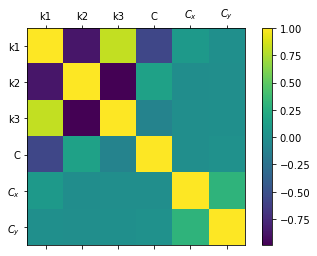

In [4]:
# Calaculate convariance matrix
cov = inv(np.transpose(jacobian) * np.matrix(jacobian))

# Normalise covariance matrix
nm = np.diag(np.power(np.diag(cov), -0.5))
corr = nm * cov * nm

# Visualise
names = ['', 'k1', 'k2', 'k3', 'C', '$C_x$', '$C_y$']
corr = corr[0:6, 0:6]
fig, ax = plt.subplots()
cax = ax.matshow(corr)
fig.colorbar(cax)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

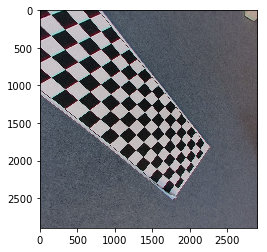

In [5]:
# Visual verification

im = cv2.imread('images/calib3/15.jpg')
im = im[0:im.shape[0], 0:im.shape[0]]

K = np.matrix([
    [params[3], 0, params[4]],
    [0, params[3], params[5]],
    [0, 0, 1]
])
D = np.concatenate([params[0:3], [0]])

mapx, mapy = cv2.fisheye.initUndistortRectifyMap(K, D, None, K, (im.shape[0], im.shape[1]), cv2.CV_16SC2)
uim = cv2.remap(im, mapx, mapy, cv2.INTER_LINEAR)

plt.imshow(uim)

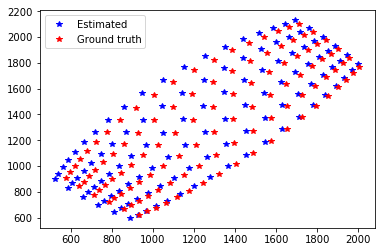

In [6]:
# Visualise residuals for a single image

from topocalib.model_cv import get_pixel_coordinates

IMG_ID = 0

estimated = np.empty([0, 2])
for pixel, point in zip(imgpoints[IMG_ID], objpoints[IMG_ID]):
    X_c = get_pixel_coordinates(T_all[IMG_ID], R_all[IMG_ID], point, ks, C, center)
    estimated = np.append(estimated, np.transpose(X_c), axis=0)
    
plt.plot(estimated[:, 0], estimated[:, 1], 'b*', label='Estimated')
plt.plot(imgpoints[IMG_ID][:, 0], imgpoints[IMG_ID][:, 1], 'r*', label='Ground truth')
plt.legend()


(array([ 5.,  2.,  5.,  3.,  3.,  5.,  4.,  4.,  6.,  3.,  3.,  5.,  3.,
         3.,  3.,  7.,  8., 14., 16., 12.]),
 array([16.47290733, 18.66539428, 20.85788122, 23.05036817, 25.24285512,
        27.43534207, 29.62782902, 31.82031597, 34.01280292, 36.20528987,
        38.39777682, 40.59026377, 42.78275072, 44.97523767, 47.16772462,
        49.36021157, 51.55269852, 53.74518547, 55.93767241, 58.13015936,
        60.32264631]),
 <a list of 20 Patch objects>)

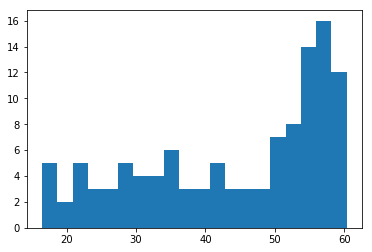

In [7]:
# Plot histogram of residuals

resid = imgpoints[IMG_ID] - estimated
resid_dist = np.sqrt(resid[:, 0]**2 + resid[:, 1]**2)
plt.hist(resid_dist, bins=20)